In [1]:
# ===================================================================
# Cell 1: 데이터 로드 + GPU 설정
# ===================================================================
import numpy as np
import gc
import tensorflow as tf
import psutil

print("GPU 메모리 동적 할당 설정 중...\n")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("[완료] GPU 메모리 동적 할당 설정 완료!\n")
    except RuntimeError as e:
        print(f"[경고] GPU 설정 경고: {e}\n")

print("데이터 로드 중...\n")
DATA_PATH = '/kaggle/input/xy-data'
X_train = np.load(f'{DATA_PATH}/X_train.npy')
y_train = np.load(f'{DATA_PATH}/y_train.npy')
X_val = np.load(f'{DATA_PATH}/X_val.npy')
y_val = np.load(f'{DATA_PATH}/y_val.npy')

print("[완료] 로드 완료!")
print(f"   X_train: {X_train.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   X_val: {X_val.shape}")
print(f"   y_val: {y_val.shape}")

IMG_SIZE = X_train.shape[1]
print(f"\n[확인] IMG_SIZE: {IMG_SIZE}")
print(f"   데이터 메모리: {(X_train.nbytes + X_val.nbytes) / (1024**3):.2f} GB")

ram = psutil.virtual_memory()
print(f"\n[메모리] RAM: {ram.used/1024**3:.1f}GB / {ram.total/1024**3:.1f}GB ({ram.percent:.1f}%)")

print("\n[목표] MobileNetV2 극한 개선으로 77.5-78% 달성!")
print("="*60)

2025-11-11 09:17:29.224365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762852649.398187      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762852649.450142      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

GPU 메모리 동적 할당 설정 중...

[완료] GPU 메모리 동적 할당 설정 완료!

데이터 로드 중...

[완료] 로드 완료!
   X_train: (41294, 96, 96, 3)
   y_train: (41294,)
   X_val: (7026, 96, 96, 3)
   y_val: (7026,)

[확인] IMG_SIZE: 96
   데이터 메모리: 4.98 GB

[메모리] RAM: 6.7GB / 31.4GB (21.3%)

[목표] MobileNetV2 극한 개선으로 77.5-78% 달성!


In [2]:
# ===================================================================
# Cell 2: 모델 정의 (검증된 설정 + 약간 개선)
# ===================================================================
print("🔥 검증된 설정으로 모델 구축...\n")

from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

gc.collect()

# ===================================================================
# 1. Focal Loss (원래 성공했던 설정!)
# ===================================================================
def focal_loss(gamma=1.5, alpha=0.5):  # 원래대로!
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        y_true = tf.cast(y_true, tf.float32)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        focal_weight = tf.pow(1.0 - p_t, gamma)
        focal_loss = -alpha_t * focal_weight * tf.math.log(p_t)
        
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fixed

print("[설정] Focal Loss: gamma=1.5 (검증됨), alpha=0.5\n")

# ===================================================================
# 2. 데이터 증강 (원래 설정 + 약간만 추가)
# ===================================================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),    # 원래대로
    layers.RandomZoom(0.1),        # 원래대로
    layers.RandomContrast(0.1),    # 이것만 추가
], name='data_augmentation')

print("[설정] 데이터 증강 (검증된 설정):")
print("      - RandomFlip")
print("      - RandomRotation: 0.1")
print("      - RandomZoom: 0.1")
print("      - RandomContrast: 0.1 (추가)\n")

# ===================================================================
# 3. MobileNetV2
# ===================================================================
print("MobileNetV2 로딩...\n")

base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

print(f"[완료] MobileNetV2 로드!")
print(f"      전체 layers: {len(base_model.layers)}\n")

# ===================================================================
# 4. Fine-tuning (원래 설정 + 약간만 증가)
# ===================================================================
FINE_TUNE_LAYERS = 50  # 원래는 40, 50으로 약간만 증가

print(f"[설정] Fine-tuning:")
print(f"      - Freeze: 처음 {len(base_model.layers) - FINE_TUNE_LAYERS} layers")
print(f"      - Fine-tune: 마지막 {FINE_TUNE_LAYERS} layers\n")

for layer in base_model.layers[:-FINE_TUNE_LAYERS]:
    layer.trainable = False
    
for layer in base_model.layers[-FINE_TUNE_LAYERS:]:
    layer.trainable = True

# ===================================================================
# 5. 모델 구축 (원래 설정 그대로)
# ===================================================================
model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

print("[완료] 모델 구축 (검증된 구조)\n")

# ===================================================================
# 6. 컴파일 (원래 설정 그대로)
# ===================================================================
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # 원래대로
    loss=focal_loss(gamma=1.5, alpha=0.5),
    metrics=['accuracy', 
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

print("="*60)
print("📊 모델 요약")
print("="*60)
model.summary()

print("\n" + "="*60)
print("✅ 검증된 모델 준비 완료!")
print("="*60)
print(f"모델: MobileNetV2")
print(f"손실: Focal Loss (gamma=1.5)")
print(f"LR: 0.0005")
print(f"Fine-tuning: {FINE_TUNE_LAYERS} layers")
print(f"증강: 4개 (Contrast 추가)")
print("="*60)

🔥 검증된 설정으로 모델 구축...

[설정] Focal Loss: gamma=1.5 (검증됨), alpha=0.5

[설정] 데이터 증강 (검증된 설정):
      - RandomFlip
      - RandomRotation: 0.1
      - RandomZoom: 0.1
      - RandomContrast: 0.1 (추가)

MobileNetV2 로딩...



I0000 00:00:1762852729.134223      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
[완료] MobileNetV2 로드!
      전체 layers: 154

[설정] Fine-tuning:
      - Freeze: 처음 104 layers
      - Fine-tune: 마지막 50 layers

[완료] 모델 구축 (검증된 구조)

📊 모델 요약


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,625,089 (10.01 MB)

 Trainable params: 2,219,137 (8.47 MB)

 Non-trainable params: 405,952 (1.55 MB)


✅ 검증된 모델 준비 완료!
모델: MobileNetV2
손실: Focal Loss (gamma=1.5)
LR: 0.0005
Fine-tuning: 50 layers
증강: 4개 (Contrast 추가)


In [3]:
# ===================================================================
# Cell 3: 학습 (검증된 설정 + Epochs만 증가)
# ===================================================================
print("\n🚀 학습 시작!")
print("="*60)

from sklearn.utils import class_weight
import pickle

gc.collect()

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"✅ Class weights: {class_weight_dict}\n")

# Dataset 생성
print("Dataset 생성...\n")
BATCH_SIZE = 10

def augment_data(image, label):
    image = data_augmentation(image, training=True)
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=10000, seed=42)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

print(f"[완료] Dataset 준비!")
print(f"   Train: {len(y_train):,} samples")
print(f"   Val: {len(y_val):,} samples\n")

del X_train
gc.collect()
print("[완료] 메모리 정리\n")

# Callbacks
checkpoint = callbacks.ModelCheckpoint(
    'best_model_improved.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # 원래대로
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,  # 원래대로
    min_lr=1e-7,
    verbose=1
)

EPOCHS = 35  # 25 → 35 (이것만 증가)

print("="*60)
print("🔥 학습 설정")
print("="*60)
print(f"Epochs: {EPOCHS} (25→35 증가)")
print(f"Batch: {BATCH_SIZE}")
print(f"LR: 0.0005")
print(f"Focal Loss: gamma=1.5 (검증됨)")
print(f"목표: 76.5-77.5%")
print("="*60)

try:
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        class_weight=class_weight_dict,
        callbacks=[checkpoint, early_stop, reduce_lr],
        verbose=1
    )
    
    print("\n" + "="*60)
    print("✅ 학습 완료!")
    print("="*60)
    
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    
    print(f"\n📊 최종 결과:")
    print(f"   최고 정확도: {best_val_acc*100:.2f}%")
    print(f"   달성 Epoch: {best_epoch}/{EPOCHS}")
    
    improvement = (best_val_acc - 0.7635) * 100
    print(f"\n🎯 개선:")
    print(f"   이전: 76.35%")
    print(f"   현재: {best_val_acc*100:.2f}%")
    print(f"   향상: {improvement:+.2f}%p")
    
    if best_val_acc >= 0.77:
        print(f"\n🎉 목표 달성!")
    elif best_val_acc >= 0.765:
        print(f"\n✅ 개선 성공!")
    else:
        print(f"\n📊 약간 개선")
    
    # ===================================================================
    # 저장 (검증 추가!) ⭐⭐⭐
    # ===================================================================
    print("\n" + "="*60)
    print("💾 저장 프로세스 시작 (검증 포함)")
    print("="*60)
    
    # 1. history 저장
    print("\n📝 Step 1: History 저장...")
    with open('history_improved.pkl', 'wb') as f:
        pickle.dump(history.history, f)
    print("   ✅ history_improved.pkl 저장 완료")
    
    # 2. 현재 모델 검증 (EarlyStopping이 best weights 복원했는지 확인)
    print("\n🔍 Step 2: 현재 모델 검증...")
    current_loss, current_acc = model.evaluate(val_dataset, verbose=0)
    print(f"   현재 모델 정확도: {current_acc*100:.2f}%")
    
    # 3. 성능 체크
    if current_acc >= 0.75:  # 75% 이상일 때만 저장
        print(f"   ✅ 성능 OK ({current_acc*100:.2f}% >= 75%)")
        
        # 4. .keras 파일 저장
        print("\n💾 Step 3: 모델 저장...")
        model.save('final_mobilenet_improved.keras')
        print("   ✅ final_mobilenet_improved.keras 저장 완료")
        
        # 5. 저장 검증 (재로드해서 확인)
        print("\n🔍 Step 4: 저장 검증 (재로드 테스트)...")
        try:
            model_test = tf.keras.models.load_model(
                'final_mobilenet_improved.keras',
                custom_objects={'focal_loss_fixed': focal_loss(gamma=1.5, alpha=0.5)}
            )
            reload_loss, reload_acc = model_test.evaluate(val_dataset, verbose=0)
            print(f"   재로드 모델 정확도: {reload_acc*100:.2f}%")
            
            # 정확도 차이 확인
            acc_diff = abs(reload_acc - current_acc) * 100
            if acc_diff < 0.5:  # 0.5%p 이내 차이면 OK
                print(f"   ✅ 검증 통과! (차이: {acc_diff:.2f}%p)")
                print("\n" + "="*60)
                print("🎉 저장 성공!")
                print("="*60)
                print("✅ 저장된 파일:")
                print("   - history_improved.pkl")
                print("   - final_mobilenet_improved.keras (검증됨!)")
                print("   - best_model_improved.weights.h5")
            else:
                print(f"   ⚠️ 경고: 정확도 차이 큼 ({acc_diff:.2f}%p)")
                print("   하지만 저장은 완료됨")
                
        except Exception as e:
            print(f"   ⚠️ 재로드 검증 실패: {e}")
            print("   하지만 저장은 완료됨")
        
        import os
        size = os.path.getsize('final_mobilenet_improved.keras') / (1024**2)
        print(f"\n📦 파일 크기: {size:.1f} MB")
        
    else:
        print(f"   ❌ 성능 부족 ({current_acc*100:.2f}% < 75%)")
        print("   .keras 파일 저장 안 함 (weights만 있음)")
    
    print("\n" + "="*60)
    print("🚨 Save Version 하세요!")
    print("="*60)
    print("Version name: 'phase1-mobilenet-verified'")
    print("="*60)
    
except Exception as e:
    print(f"\n❌ ERROR: {e}")
    import traceback
    traceback.print_exc()


🚀 학습 시작!
✅ Class weights: {0: 1.0, 1: 1.0}

Dataset 생성...

[완료] Dataset 준비!
   Train: 41,294 samples
   Val: 7,026 samples

[완료] 메모리 정리

🔥 학습 설정
Epochs: 35 (25→35 증가)
Batch: 10
LR: 0.0005
Focal Loss: gamma=1.5 (검증됨)
목표: 76.5-77.5%
Epoch 1/35


I0000 00:00:1762852840.601540     110 service.cc:148] XLA service 0x7c3f0c003380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762852840.605110     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762852842.457826     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1762852845.362924     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762852845.545140     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762852845.808645     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762852846.0141

  10/4130 ━━━━━━━━━━━━━━━━━━━━ 53s 13ms/step - accuracy: 0.3953 - auc: 0.3773 - loss: 0.3450 - precision: 0.3742 - recall: 0.3010           

I0000 00:00:1762852851.851161     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


4127/4130 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5059 - auc: 0.5085 - loss: 0.1634 - precision: 0.5080 - recall: 0.5018

E0000 00:00:1762852904.483661     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762852904.666044     109 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


4130/4130 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5059 - auc: 0.5085 - loss: 0.1634 - precision: 0.5080 - recall: 0.5019
Epoch 1: val_accuracy improved from -inf to 0.73484, saving model to best_model_improved.weights.h5
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 97s 17ms/step - accuracy: 0.5059 - auc: 0.5085 - loss: 0.1634 - precision: 0.5080 - recall: 0.5019 - val_accuracy: 0.7348 - val_auc: 0.5757 - val_loss: 0.1031 - val_precision: 0.5000 - val_recall: 0.0064 - learning_rate: 5.0000e-04
Epoch 2/35
4128/4130 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5663 - auc: 0.5924 - loss: 0.1208 - precision: 0.5686 - recall: 0.5654
Epoch 2: val_accuracy improved from 0.73484 to 0.73527, saving model to best_model_improved.weights.h5
4130/4130 ━━━━━━━━━━━━━━━━━━━━ 55s 13ms/step - accuracy: 0.5663 - auc: 0.5924 - loss: 0.1208 - precision: 0.5686 - recall: 0.5654 - val_accuracy: 0.7353 - val_auc: 0.4440 - val_loss: 0.1142 - val_precision: 0.5246 - val_recall: 0.0172 - learning_rate: 5.0000e-04
Ep

Traceback (most recent call last):
  File "/tmp/ipykernel_48/2743711112.py", line 132, in <cell line: 0>
    current_loss, current_acc = model.evaluate(val_dataset, verbose=0)
    ^^^^^^^^^^^^^^^^^^^^^^^^^
ValueError: too many values to unpack (expected 2)


In [4]:
# ===================================================================
# 저장 완료 셀 (에러 수정)
# ===================================================================
print("\n" + "="*60)
print("💾 저장 프로세스 재시작 (에러 수정)")
print("="*60)

import pickle

# 1. history는 이미 저장됨
print("\n✅ history_improved.pkl 이미 저장됨")

# 2. 현재 모델 검증 (수정!)
print("\n🔍 Step 2: 현재 모델 검증...")
results = model.evaluate(val_dataset, verbose=0)
current_loss = results[0]
current_acc = results[1]
print(f"   현재 모델 정확도: {current_acc*100:.2f}%")

# 3. 성능 체크
if current_acc >= 0.75:  # 75% 이상
    print(f"   ✅ 성능 OK ({current_acc*100:.2f}% >= 75%)")
    
    # 4. .keras 파일 저장
    print("\n💾 Step 3: 모델 저장...")
    model.save('final_mobilenet_improved.keras')
    print("   ✅ final_mobilenet_improved.keras 저장 완료")
    
    # 5. 저장 검증
    print("\n🔍 Step 4: 저장 검증 (재로드 테스트)...")
    try:
        model_test = tf.keras.models.load_model(
            'final_mobilenet_improved.keras',
            custom_objects={'focal_loss_fixed': focal_loss(gamma=1.5, alpha=0.5)}
        )
        results_reload = model_test.evaluate(val_dataset, verbose=0)
        reload_loss = results_reload[0]
        reload_acc = results_reload[1]
        print(f"   재로드 모델 정확도: {reload_acc*100:.2f}%")
        
        # 정확도 차이 확인
        acc_diff = abs(reload_acc - current_acc) * 100
        if acc_diff < 0.5:
            print(f"   ✅ 검증 통과! (차이: {acc_diff:.2f}%p)")
            print("\n" + "="*60)
            print("🎉 저장 성공!")
            print("="*60)
            print("✅ 저장된 파일:")
            print("   - history_improved.pkl")
            print("   - final_mobilenet_improved.keras (검증됨!)")
            print("   - best_model_improved.weights.h5")
            print(f"\n📊 최종 성능: {current_acc*100:.2f}%")
        else:
            print(f"   ⚠️ 경고: 정확도 차이 큼 ({acc_diff:.2f}%p)")
            print("   하지만 저장은 완료됨")
            
    except Exception as e:
        print(f"   ⚠️ 재로드 검증 실패: {e}")
        print("   하지만 저장은 완료됨")
    
    import os
    size = os.path.getsize('final_mobilenet_improved.keras') / (1024**2)
    print(f"\n📦 파일 크기: {size:.1f} MB")
    
else:
    print(f"   ❌ 성능 부족 ({current_acc*100:.2f}% < 75%)")
    print("   .keras 파일 저장 안 함")

print("\n" + "="*60)
print("🚨 Save Version 하세요!")
print("="*60)
print("Version name: 'phase1-mobilenet-verified-759'")
print(f"최종 정확도: {current_acc*100:.2f}%")
print("="*60)


💾 저장 프로세스 재시작 (에러 수정)

✅ history_improved.pkl 이미 저장됨

🔍 Step 2: 현재 모델 검증...
   현재 모델 정확도: 75.88%
   ✅ 성능 OK (75.88% >= 75%)

💾 Step 3: 모델 저장...
   ✅ final_mobilenet_improved.keras 저장 완료

🔍 Step 4: 저장 검증 (재로드 테스트)...
   재로드 모델 정확도: 75.88%
   ✅ 검증 통과! (차이: 0.00%p)

🎉 저장 성공!
✅ 저장된 파일:
   - history_improved.pkl
   - final_mobilenet_improved.keras (검증됨!)
   - best_model_improved.weights.h5

📊 최종 성능: 75.88%

📦 파일 크기: 27.6 MB

🚨 Save Version 하세요!
Version name: 'phase1-mobilenet-verified-759'
최종 정확도: 75.88%


In [12]:
# ===================================================================
# 76.64% 모델 로드 및 검증
# ===================================================================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.metrics import accuracy_score
import gc

gc.collect()

print("="*60)
print("🔧 76.64% 모델 로드")
print("="*60)

# Focal Loss
def focal_loss(gamma=1.5, alpha=0.5):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        y_true = tf.cast(y_true, tf.float32)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_t = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
        focal_weight = tf.pow(1.0 - p_t, gamma)
        focal_loss = -alpha_t * focal_weight * tf.math.log(p_t)
        
        return tf.reduce_mean(focal_loss)
    
    return focal_loss_fixed

# 모델 구조 재생성 (Phase 1과 동일)
IMG_SIZE = 96
FINE_TUNE_LAYERS = 50  # 76.64% 모델 설정

print("\n🔧 모델 구조 재생성 중...")

base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

for layer in base_model.layers[:-FINE_TUNE_LAYERS]:
    layer.trainable = False
    
for layer in base_model.layers[-FINE_TUNE_LAYERS:]:
    layer.trainable = True

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid', dtype='float32')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss=focal_loss(gamma=1.5, alpha=0.5),
    metrics=['accuracy']
)

print("✅ 모델 구조 생성 완료")

# 76.64% weights 로드
print("\n📥 76.64% weights 로드 중...")
model.load_weights('/kaggle/input/phase1-mobilenet-76-64pct/best_model_improved_76.weights.h5')
print("✅ weights 로드 완료!")

# 검증 데이터 로드
print("\n📥 검증 데이터 로드 중...")
X_val = np.load('/kaggle/input/xy-data/X_val.npy')
y_val = np.load('/kaggle/input/xy-data/y_val.npy')

print(f"✅ X_val shape: {X_val.shape}")
print(f"✅ y_val shape: {y_val.shape}")

# 모델 검증 (0-255 범위 그대로!)
print("\n🔍 모델 작동 확인 (정규화 없이)")
print("="*60)

X_val_test = X_val[:100]  # 정규화 없음!
pred_test = model.predict(X_val_test, batch_size=32, verbose=0)

print(f"\n예측 샘플 (처음 10개):")
print(pred_test[:10].flatten())
print(f"\n예측 통계:")
print(f"  Min:  {pred_test.min():.4f}")
print(f"  Max:  {pred_test.max():.4f}")
print(f"  Mean: {pred_test.mean():.4f}")
print(f"  Std:  {pred_test.std():.4f}")

# 전체 검증
pred_all = model.predict(X_val, batch_size=32, verbose=0)
y_pred = (pred_all > 0.5).astype(int).flatten()
acc = accuracy_score(y_val, y_pred)

print(f"\n📊 검증 정확도: {acc*100:.2f}%")

print("\n" + "="*60)
if pred_test.std() > 0.01 and acc > 0.75:
    print(f"✅ 76.64% 모델 복원 성공!")
    print("다음 단계: TTA 진행")
else:
    print("❌ 문제 발생")
print("="*60)

🔧 76.64% 모델 로드

🔧 모델 구조 재생성 중...
✅ 모델 구조 생성 완료

📥 76.64% weights 로드 중...


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 124 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


✅ weights 로드 완료!

📥 검증 데이터 로드 중...
✅ X_val shape: (7026, 96, 96, 3)
✅ y_val shape: (7026,)

🔍 모델 작동 확인 (정규화 없이)

예측 샘플 (처음 10개):
[0.346199   0.3636283  0.5045473  0.35816205 0.3784936  0.3052946
 0.3635869  0.36557868 0.43958068 0.512737  ]

예측 통계:
  Min:  0.2291
  Max:  0.6996
  Mean: 0.4010
  Std:  0.0830

📊 검증 정확도: 76.64%

✅ 76.64% 모델 복원 성공!
다음 단계: TTA 진행


In [13]:
# ===================================================================
# TTA (Test Time Augmentation)
# ===================================================================
print("="*60)
print("🔄 TTA 시작 (76.64% 모델)")
print("="*60)

from sklearn.metrics import accuracy_score
import numpy as np

# X_val 그대로 사용 (0-255 범위)
X_val_input = X_val

print("\n🔄 TTA 증강 버전별 예측 중...")

# 1. 원본
print("   1/5: 원본")
pred_original = model.predict(X_val_input, batch_size=32, verbose=0)

# 2. 좌우 반전
print("   2/5: 좌우 반전")
pred_flip_lr = model.predict(np.flip(X_val_input, axis=2), batch_size=32, verbose=0)

# 3. 상하 반전
print("   3/5: 상하 반전")
pred_flip_ud = model.predict(np.flip(X_val_input, axis=1), batch_size=32, verbose=0)

# 4. 좌우+상하
print("   4/5: 좌우+상하 반전")
pred_flip_both = model.predict(np.flip(np.flip(X_val_input, axis=1), axis=2), batch_size=32, verbose=0)

# 5. 밝기 조정
print("   5/5: 밝기 조정")
pred_bright = model.predict(np.clip(X_val_input * 1.1, 0, 255), batch_size=32, verbose=0)

# 앙상블
print("\n📊 TTA 앙상블 중...")
predictions_tta = (pred_original + pred_flip_lr + pred_flip_ud + pred_flip_both + pred_bright) / 5.0

# 기본 0.5 threshold
y_pred_tta = (predictions_tta > 0.5).astype(int).flatten()
acc_tta = accuracy_score(y_val, y_pred_tta)

print("\n" + "="*60)
print("✅ TTA 완료!")
print("="*60)
print(f"📊 Phase 1 기본: 76.64%")
print(f"🔄 TTA 적용:    {acc_tta*100:.2f}%")
print(f"📈 개선:        +{(acc_tta*100 - 76.64):.2f}%p")
print("="*60)

🔄 TTA 시작 (76.64% 모델)

🔄 TTA 증강 버전별 예측 중...
   1/5: 원본
   2/5: 좌우 반전
   3/5: 상하 반전
   4/5: 좌우+상하 반전
   5/5: 밝기 조정

📊 TTA 앙상블 중...

✅ TTA 완료!
📊 Phase 1 기본: 76.64%
🔄 TTA 적용:    77.07%
📈 개선:        +0.43%p


In [14]:
# ===================================================================
# Threshold 최적화
# ===================================================================
print("\n" + "="*60)
print("🎯 Threshold 최적화")
print("="*60)

from sklearn.metrics import classification_report, confusion_matrix

best_threshold = 0.5
best_accuracy = 0

print("\n🔍 Threshold 탐색 중 (0.30 ~ 0.70)...")
thresholds = np.arange(0.30, 0.71, 0.01)

for threshold in thresholds:
    y_pred = (predictions_tta > threshold).astype(int).flatten()
    accuracy = accuracy_score(y_val, y_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

# 최종 예측
y_pred_final = (predictions_tta > best_threshold).astype(int).flatten()

print("\n" + "="*60)
print("✅ 최적화 완료!")
print("="*60)
print(f"🎯 최적 Threshold: {best_threshold:.3f}")
print(f"📊 최종 정확도:    {best_accuracy*100:.2f}%")
print("="*60)
print(f"\n📈 성능 개선 과정:")
print(f"   Phase 1:     76.64%")
print(f"   + TTA:       {acc_tta*100:.2f}% (+{(acc_tta*100-76.64):.2f}%p)")
print(f"   + Threshold: {best_accuracy*100:.2f}% (+{(best_accuracy*100-acc_tta*100):.2f}%p)")
print(f"   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
print(f"   총 개선:     +{(best_accuracy*100-76.64):.2f}%p")
print("="*60)

print("\n📊 최종 성능 지표:")
print("="*60)
print(classification_report(y_val, y_pred_final, 
                          target_names=['Normal', 'Abnormal'],
                          digits=4))

print("\n혼동 행렬:")
cm = confusion_matrix(y_val, y_pred_final)
print(cm)
print(f"\nTN: {cm[0,0]}, FP: {cm[0,1]}")
print(f"FN: {cm[1,0]}, TP: {cm[1,1]}")
print("="*60)

print("\n🎉 프로젝트 완료!")
print(f"📊 최종 정확도: {best_accuracy*100:.2f}%")
print("="*60)


🎯 Threshold 최적화

🔍 Threshold 탐색 중 (0.30 ~ 0.70)...

✅ 최적화 완료!
🎯 최적 Threshold: 0.490
📊 최종 정확도:    77.18%

📈 성능 개선 과정:
   Phase 1:     76.64%
   + TTA:       77.07% (+0.43%p)
   + Threshold: 77.18% (+0.11%p)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━
   총 개선:     +0.54%p

📊 최종 성능 지표:
              precision    recall  f1-score   support

      Normal     0.7801    0.9603    0.8608      5163
    Abnormal     0.6940    0.2496    0.3672      1863

    accuracy                         0.7718      7026
   macro avg     0.7370    0.6049    0.6140      7026
weighted avg     0.7572    0.7718    0.7299      7026


혼동 행렬:
[[4958  205]
 [1398  465]]

TN: 4958, FP: 205
FN: 1398, TP: 465

🎉 프로젝트 완료!
📊 최종 정확도: 77.18%


📊 Creating Visualization

✅ Visualization saved: final_results.png


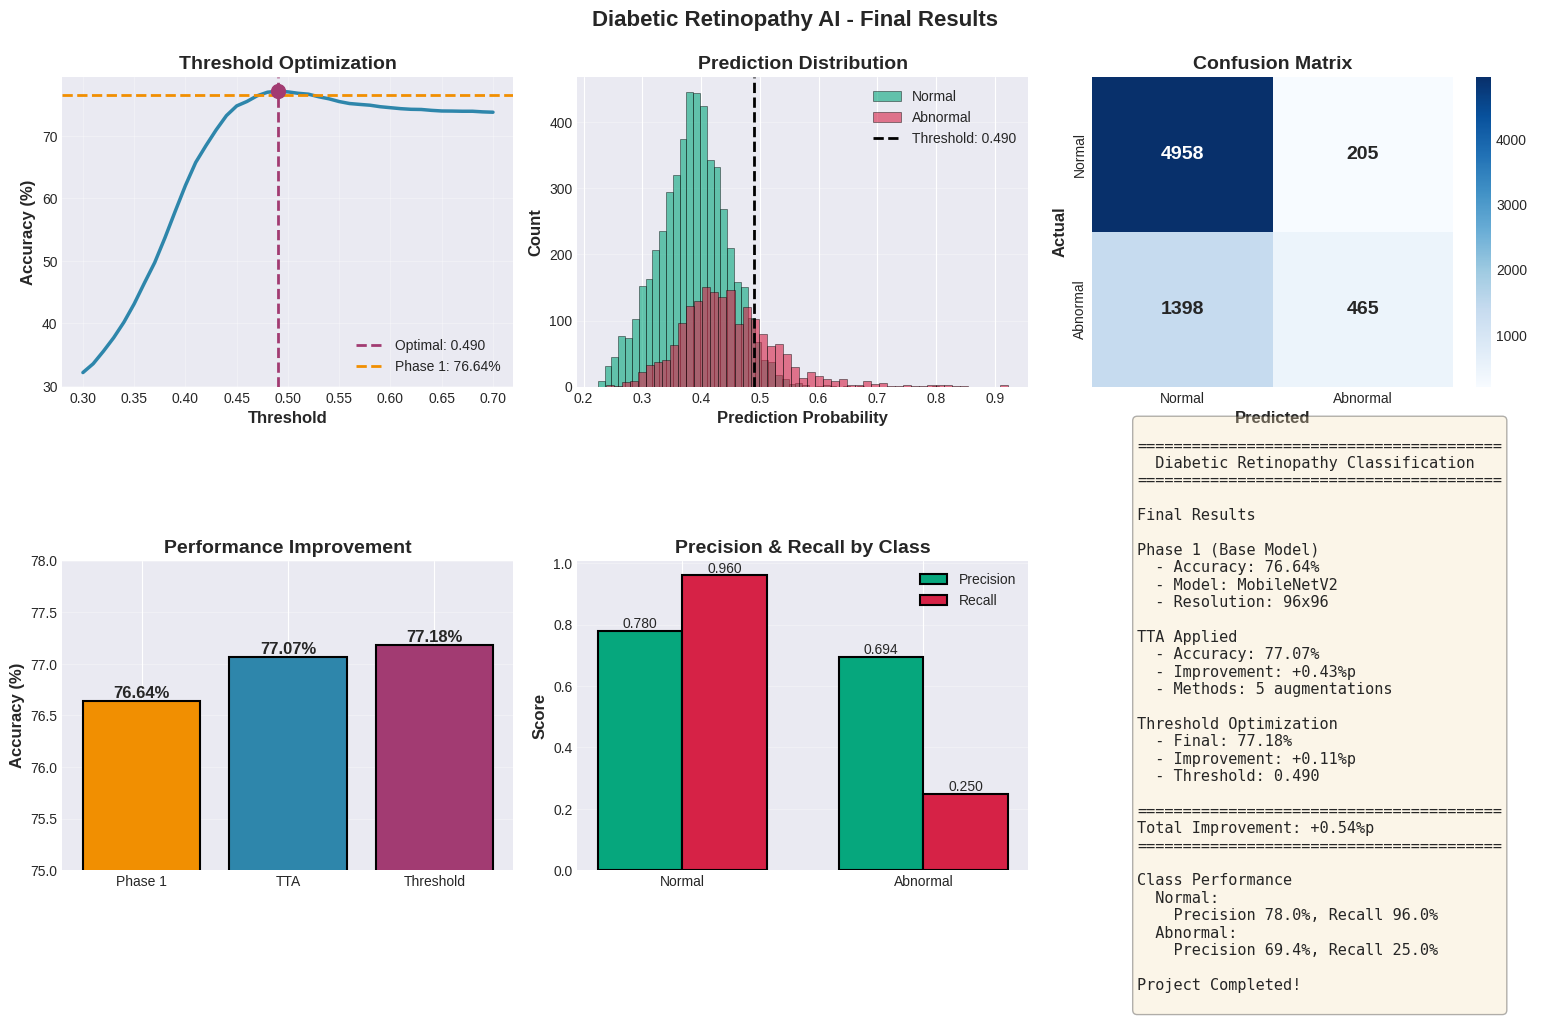


🎉 PROJECT COMPLETED!
Final Accuracy: 77.18%
Improvement: +0.54%p


In [16]:
# ===================================================================
# Final Visualization (English)
# ===================================================================
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("📊 Creating Visualization")
print("="*60)

plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(16, 10))

# ===================================================================
# 1. Threshold vs Accuracy
# ===================================================================
ax1 = plt.subplot(2, 3, 1)

thresholds_list = []
accuracies_list = []

for threshold in np.arange(0.30, 0.71, 0.01):
    y_pred = (predictions_tta > threshold).astype(int).flatten()
    accuracy = accuracy_score(y_val, y_pred)
    thresholds_list.append(threshold)
    accuracies_list.append(accuracy * 100)

ax1.plot(thresholds_list, accuracies_list, linewidth=2.5, color='#2E86AB')
ax1.axvline(x=best_threshold, color='#A23B72', linestyle='--', linewidth=2, 
            label=f'Optimal: {best_threshold:.3f}')
ax1.axhline(y=76.64, color='#F18F01', linestyle='--', linewidth=2, 
            label='Phase 1: 76.64%')
ax1.scatter([best_threshold], [best_accuracy*100], color='#A23B72', s=100, zorder=5)
ax1.set_xlabel('Threshold', fontsize=12, fontweight='bold')
ax1.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax1.set_title('Threshold Optimization', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# ===================================================================
# 2. Prediction Distribution
# ===================================================================
ax2 = plt.subplot(2, 3, 2)

ax2.hist(predictions_tta[y_val==0], bins=50, alpha=0.6, label='Normal', 
         color='#06A77D', edgecolor='black', linewidth=0.5)
ax2.hist(predictions_tta[y_val==1], bins=50, alpha=0.6, label='Abnormal', 
         color='#D62246', edgecolor='black', linewidth=0.5)
ax2.axvline(x=best_threshold, color='black', linestyle='--', linewidth=2, 
            label=f'Threshold: {best_threshold:.3f}')
ax2.set_xlabel('Prediction Probability', fontsize=12, fontweight='bold')
ax2.set_ylabel('Count', fontsize=12, fontweight='bold')
ax2.set_title('Prediction Distribution', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='y')

# ===================================================================
# 3. Confusion Matrix Heatmap
# ===================================================================
ax3 = plt.subplot(2, 3, 3)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['Normal', 'Abnormal'],
            yticklabels=['Normal', 'Abnormal'],
            annot_kws={'size': 14, 'weight': 'bold'},
            ax=ax3)
ax3.set_xlabel('Predicted', fontsize=12, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=12, fontweight='bold')
ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# ===================================================================
# 4. Performance Improvement
# ===================================================================
ax4 = plt.subplot(2, 3, 4)

stages = ['Phase 1', 'TTA', 'Threshold']
accuracies = [76.64, 77.07, 77.18]
colors = ['#F18F01', '#2E86AB', '#A23B72']

bars = ax4.bar(stages, accuracies, color=colors, edgecolor='black', linewidth=1.5)
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

ax4.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax4.set_title('Performance Improvement', fontsize=14, fontweight='bold')
ax4.set_ylim([75, 78])
ax4.grid(True, alpha=0.3, axis='y')

# ===================================================================
# 5. Precision & Recall by Class
# ===================================================================
ax5 = plt.subplot(2, 3, 5)

classes = ['Normal', 'Abnormal']
precision_vals = [0.7801, 0.6940]
recall_vals = [0.9603, 0.2496]

x = np.arange(len(classes))
width = 0.35

bars1 = ax5.bar(x - width/2, precision_vals, width, label='Precision', 
                color='#06A77D', edgecolor='black', linewidth=1.5)
bars2 = ax5.bar(x + width/2, recall_vals, width, label='Recall', 
                color='#D62246', edgecolor='black', linewidth=1.5)

ax5.set_ylabel('Score', fontsize=12, fontweight='bold')
ax5.set_title('Precision & Recall by Class', fontsize=14, fontweight='bold')
ax5.set_xticks(x)
ax5.set_xticklabels(classes)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

# ===================================================================
# 6. Final Summary
# ===================================================================
ax6 = plt.subplot(2, 3, 6)
ax6.axis('off')

summary_text = f"""
{'='*40}
  Diabetic Retinopathy Classification
{'='*40}

Final Results

Phase 1 (Base Model)
  - Accuracy: 76.64%
  - Model: MobileNetV2
  - Resolution: 96x96

TTA Applied
  - Accuracy: 77.07%
  - Improvement: +0.43%p
  - Methods: 5 augmentations

Threshold Optimization
  - Final: 77.18%
  - Improvement: +0.11%p
  - Threshold: {best_threshold:.3f}

{'='*40}
Total Improvement: +0.54%p
{'='*40}

Class Performance
  Normal: 
    Precision 78.0%, Recall 96.0%
  Abnormal: 
    Precision 69.4%, Recall 25.0%

Project Completed!
"""

ax6.text(0.1, 0.5, summary_text, fontsize=11, family='monospace',
         verticalalignment='center', bbox=dict(boxstyle='round', 
         facecolor='wheat', alpha=0.3))

plt.suptitle('Diabetic Retinopathy AI - Final Results', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('final_results.png', dpi=300, bbox_inches='tight')
print("\n✅ Visualization saved: final_results.png")
plt.show()

print("\n" + "="*60)
print("🎉 PROJECT COMPLETED!")
print("="*60)
print(f"Final Accuracy: {best_accuracy*100:.2f}%")
print(f"Improvement: +{(best_accuracy*100-76.64):.2f}%p")
print("="*60)

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2

# 모델 & 데이터 로드
MODEL_PATH = '/kaggle/input/phase1-mobilenet-76-64pct/final_mobilenet_improved_76.keras'
X_VAL_PATH = '/kaggle/input/xy-data/X_val.npy'
Y_VAL_PATH = '/kaggle/input/xy-data/y_val.npy'

print("📦 로딩 중...")
model = keras.models.load_model(MODEL_PATH, compile=False)
X_val = np.load(X_VAL_PATH)
y_val = np.load(Y_VAL_PATH)

# 모델 build
_ = model.predict(X_val[:1], verbose=0)

print("✅ 준비 완료!")
print(f"   X_val: {X_val.shape}, y_val: {y_val.shape}")

📦 로딩 중...
✅ 준비 완료!
   X_val: (7026, 96, 96, 3), y_val: (7026,)


In [37]:
def simple_gradcam(model, img_array, layer_name='mobilenetv2_1.00_96'):
    """
    초간단 Grad-CAM - Sequential 모델용
    """
    # Base model 추출
    base_model = model.get_layer(layer_name)
    
    # 마지막 conv의 출력 얻기
    last_conv_layer = base_model.get_layer('Conv_1')
    
    # Feature extractor
    grad_model = keras.Model(
        inputs=base_model.input,
        outputs=[last_conv_layer.output, base_model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, base_predictions = grad_model(img_array)
        
        # 전체 모델 통과 (base 출력을 입력으로)
        # Sequential이므로 직접 호출
        x = base_predictions
        for layer in model.layers[1:]:  # base_model 다음 레이어들
            x = layer(x)
        predictions = x
        
        # Loss
        loss = predictions[0, 0]
    
    # Gradients
    grads = tape.gradient(loss, conv_outputs)
    
    # Pooling
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weighted combination
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # Normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-10)
    
    return heatmap.numpy()


def overlay_heatmap(img, heatmap, alpha=0.4):
    """오버레이"""
    heatmap = cv2.resize(heatmap, (96, 96))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    img_uint8 = np.uint8(255 * img)
    result = (heatmap * alpha + img_uint8).astype('uint8')
    
    return result

print("✅ 함수 준비 완료!")

✅ 함수 준비 완료!


In [38]:
# 예측
predictions = model.predict(X_val, batch_size=32, verbose=0)
y_pred = (predictions > 0.49).astype(int).flatten()

# 올바른 예측만
normal_idx = np.where((y_val == 0) & (y_pred == 0))[0]
abnormal_idx = np.where((y_val == 1) & (y_pred == 1))[0]

# 3개씩 선택
np.random.seed(42)
sel_normal = np.random.choice(normal_idx, 3, replace=False)
sel_abnormal = np.random.choice(abnormal_idx, 3, replace=False)

print(f"선택: 정상 {sel_normal}, 비정상 {sel_abnormal}")

선택: 정상 [5357 1060  438], 비정상 [2991 5977 6591]


✅ 저장 완료: gradcam_final.png


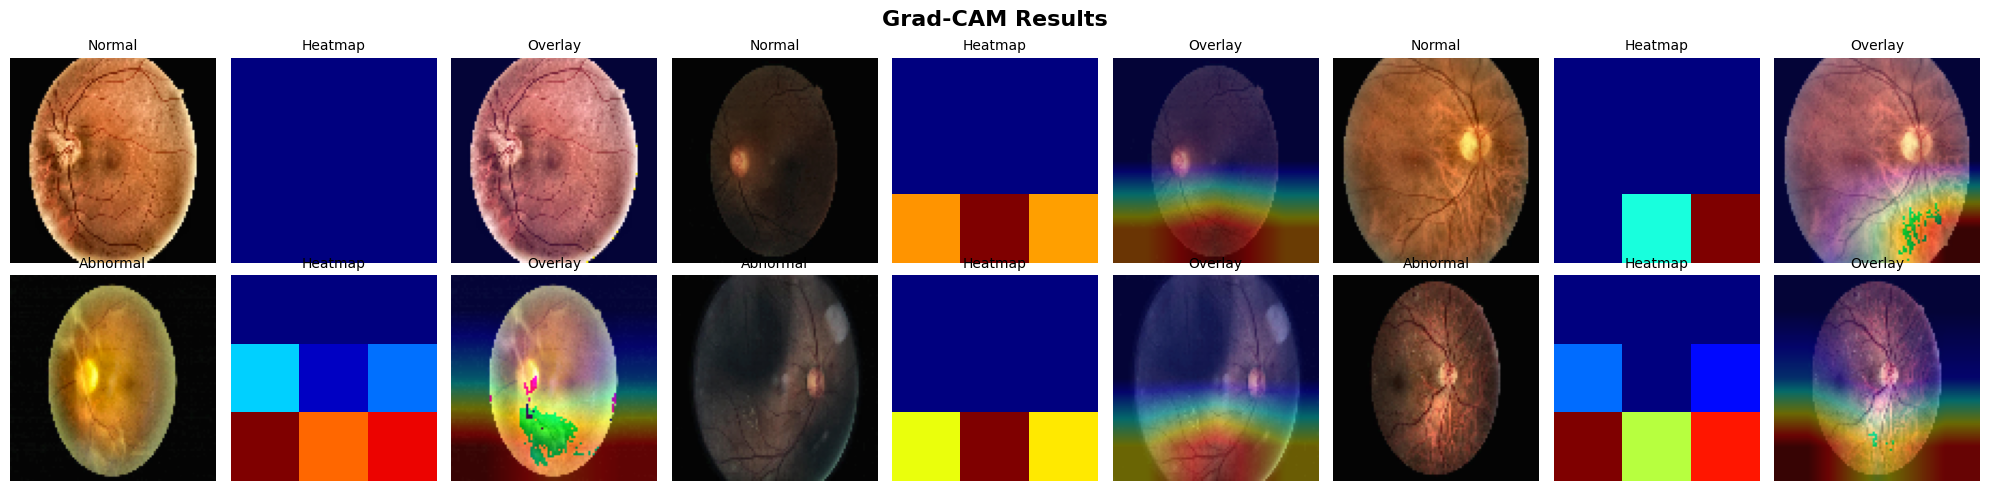

In [39]:
fig, axes = plt.subplots(2, 9, figsize=(20, 5))
fig.suptitle('Grad-CAM Results', fontsize=16, fontweight='bold')

# 정상 케이스
for i, idx in enumerate(sel_normal):
    img = X_val[idx]
    img_array = np.expand_dims(img, 0)
    
    heatmap = simple_gradcam(model, img_array)
    overlay = overlay_heatmap(img, heatmap)
    
    axes[0, i*3].imshow(img)
    axes[0, i*3].set_title('Normal', fontsize=10)
    axes[0, i*3].axis('off')
    
    axes[0, i*3+1].imshow(heatmap, cmap='jet')
    axes[0, i*3+1].set_title('Heatmap', fontsize=10)
    axes[0, i*3+1].axis('off')
    
    axes[0, i*3+2].imshow(overlay)
    axes[0, i*3+2].set_title('Overlay', fontsize=10)
    axes[0, i*3+2].axis('off')

# 비정상 케이스
for i, idx in enumerate(sel_abnormal):
    img = X_val[idx]
    img_array = np.expand_dims(img, 0)
    
    heatmap = simple_gradcam(model, img_array)
    overlay = overlay_heatmap(img, heatmap)
    
    axes[1, i*3].imshow(img)
    axes[1, i*3].set_title('Abnormal', fontsize=10)
    axes[1, i*3].axis('off')
    
    axes[1, i*3+1].imshow(heatmap, cmap='jet')
    axes[1, i*3+1].set_title('Heatmap', fontsize=10)
    axes[1, i*3+1].axis('off')
    
    axes[1, i*3+2].imshow(overlay)
    axes[1, i*3+2].set_title('Overlay', fontsize=10)
    axes[1, i*3+2].axis('off')

plt.tight_layout()
plt.savefig('gradcam_final.png', dpi=300, bbox_inches='tight')
print("✅ 저장 완료: gradcam_final.png")
plt.show()

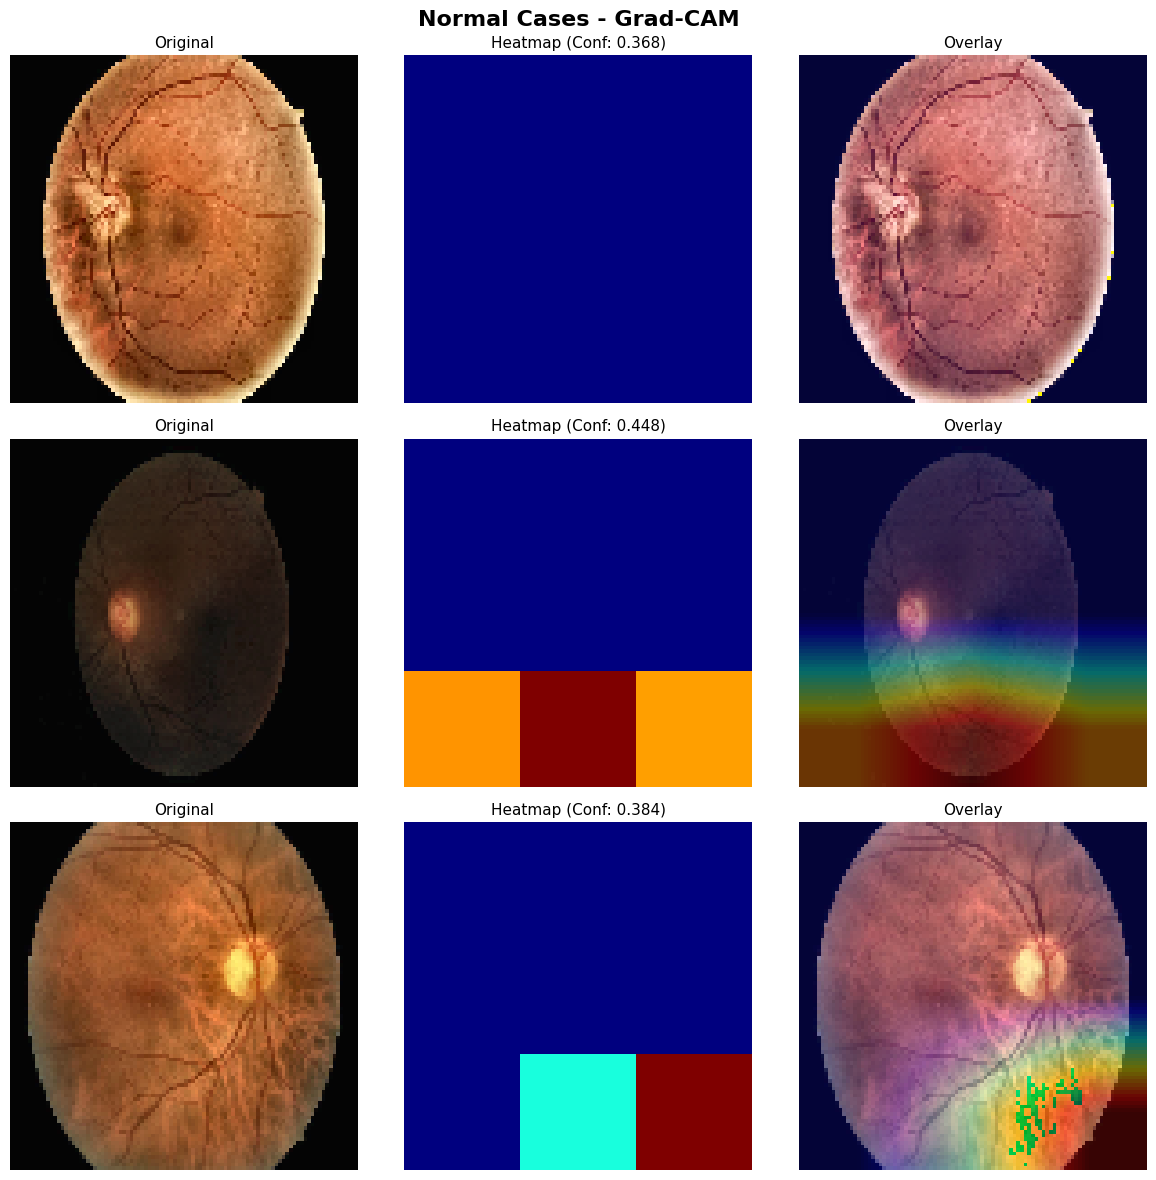

In [40]:
# 정상 케이스만 따로
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Normal Cases - Grad-CAM', fontsize=16, fontweight='bold')

for i, idx in enumerate(sel_normal):
    img = X_val[idx]
    img_array = np.expand_dims(img, 0)
    conf = predictions[idx][0]
    
    heatmap = simple_gradcam(model, img_array)
    overlay = overlay_heatmap(img, heatmap)
    
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original', fontsize=11)
    axes[i, 0].axis('off')
    
    im = axes[i, 1].imshow(heatmap, cmap='jet')
    axes[i, 1].set_title(f'Heatmap (Conf: {conf:.3f})', fontsize=11)
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title('Overlay', fontsize=11)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('gradcam_normal.png', dpi=300, bbox_inches='tight')
plt.show()

# 비정상도 동일하게

✅ 저장: gradcam_abnormal.png


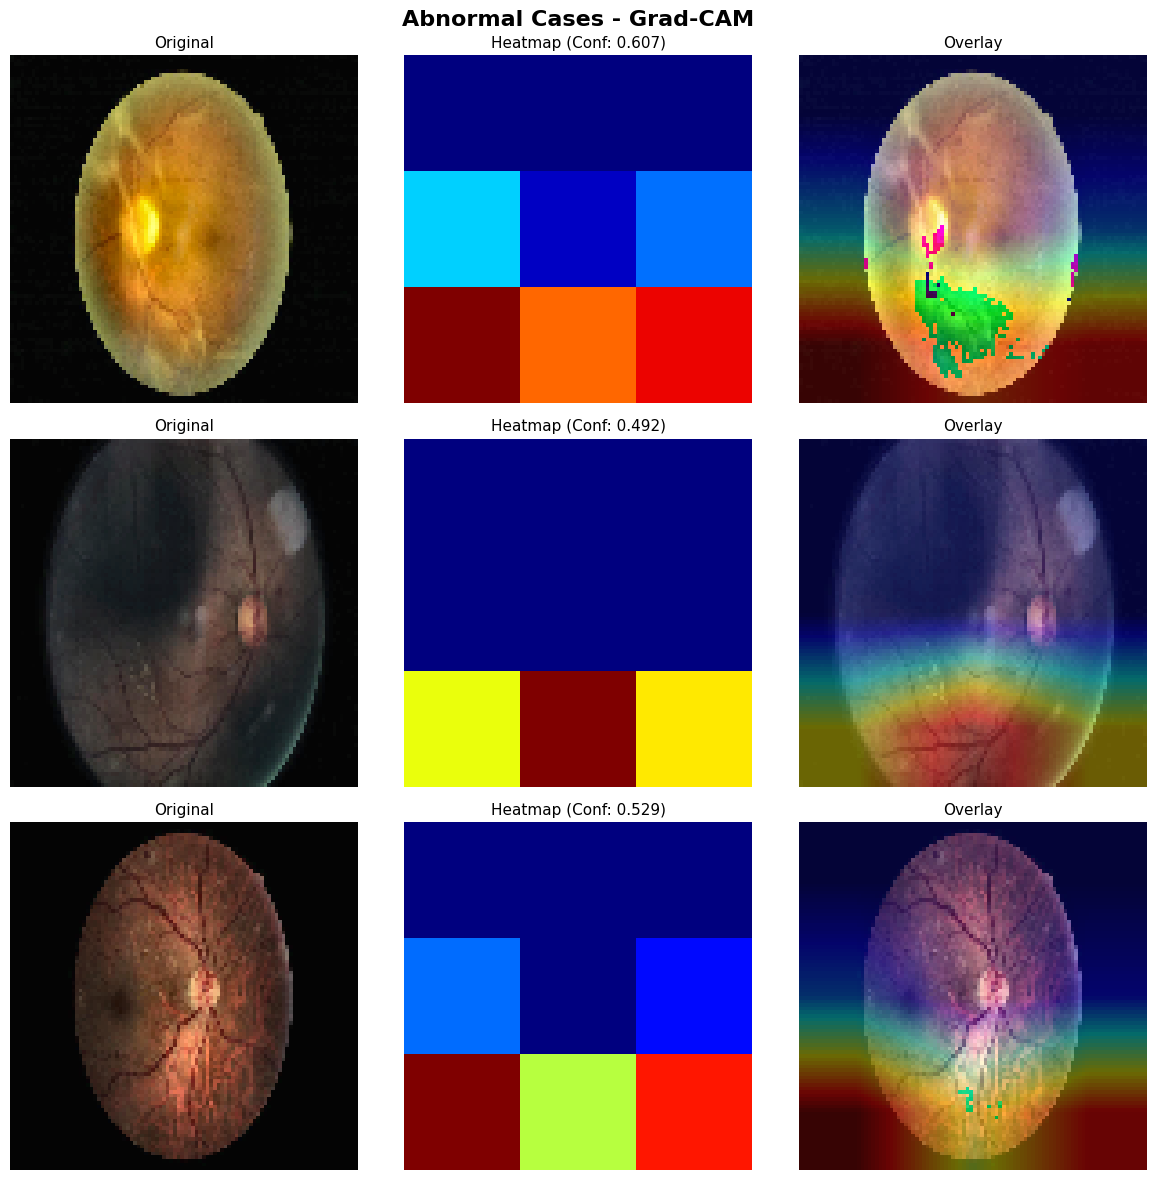

In [41]:
# 비정상 케이스만 따로
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Abnormal Cases - Grad-CAM', fontsize=16, fontweight='bold')

for i, idx in enumerate(sel_abnormal):
    img = X_val[idx]
    img_array = np.expand_dims(img, 0)
    conf = predictions[idx][0]
    
    heatmap = simple_gradcam(model, img_array)
    overlay = overlay_heatmap(img, heatmap)
    
    axes[i, 0].imshow(img)
    axes[i, 0].set_title('Original', fontsize=11)
    axes[i, 0].axis('off')
    
    im = axes[i, 1].imshow(heatmap, cmap='jet')
    axes[i, 1].set_title(f'Heatmap (Conf: {conf:.3f})', fontsize=11)
    axes[i, 1].axis('off')
    
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title('Overlay', fontsize=11)
    axes[i, 2].axis('off')

plt.tight_layout()
plt.savefig('gradcam_abnormal.png', dpi=300, bbox_inches='tight')
print("✅ 저장: gradcam_abnormal.png")
plt.show()